In [ ]:
from google.colab import drive 
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
os.getcwd()
# Change directory for nicer imports
%cd "/content/gdrive/My Drive/Data_Mining_Cup/05 Code/"

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from os import listdir
from os.path import isfile, join


info = pd.read_csv('/content/gdrive/My Drive/Data_Mining_Cup/02 Data/DMC20_Data/infos.csv', delimiter='|', index_col="itemID")
items = pd.read_csv('/content/gdrive/My Drive/Data_Mining_Cup/02 Data/DMC20_Data/items.csv', delimiter='|', index_col="itemID")
orders = pd.read_csv('/content/gdrive/My Drive/Data_Mining_Cup/02 Data/DMC20_Data/orders.csv', delimiter='|', parse_dates=True)

test_period_start = pd.to_datetime("2018-06-30")
test_period_end = pd.to_datetime("2018-07-13")

/content/gdrive/My Drive/Data_Mining_Cup/05 Code


# Submission tool

This is our little tool for comparing the different models. The submission files will be be directly taken from ur root folder of the respective team. In the later competition it is only needed to predict the full numbers of orders.

For this submission tool, u can on the one hand submit the demand for the whole time period and/or on the other hand the predictions for the 14 days between 2.6.2018 and 15.06.2018.
In case your team does the last, we are able to compare plots per day. 

The structure of the data looks the following: 

**ItemIDs** as the index of the dataframe.

**demand** as a column, describing the cumulative demand. If the column is not given the tool will simply sum the demands of the respective days.

**dates** according to the following time_range for each of the 14 days. 

The following code will create a sample submission file.

In [ ]:
time_range = list(map(lambda x: str(x), pd.date_range( end=test_period_end, periods=14)))
sample_submission = pd.DataFrame(index = items.index, columns = ['demandPrediction', *time_range])
sample_submission.to_csv('sample_submission.csv', sep='|')

To run the comparison, just go through all of the notebook. In case of questions or others, just write me (Markus) on slack and we'll see how we get it to run :)

**Good Luck**

## Preparing data

###Evaluation
The solutions submitted will be assessed and compared on the basis of their monetary value
for the retailer. The monetary value is determined by the predicted revenue and an
overstocking fee for overestimating the demand for any products. The demand prediction
for every product is therefore compared with the actual number of orders within the same
time frame.

If the demand is predicted correctly, the monetary value for that product is simply the
revenue (i.e. price x demandPrediction). If the prediction is lower than the actual number of
units sold, we assume that only the number of predicted stocks for this product will be
available and the company will fail to generate the potential revenue. As a result, the
monetary value is once again the revenue (i.e. price x demandPrediction).

If the __demand
prediction is higher than the actual number of units sold__, we assume that the remaining stock
will generate an overstocking fee of 0.6 x price x (orders - demandPrediction).
The total revenue minus the additional costs for stock clearance is the monetary value of
the solution that is submitted.

The winning team is the one whose solution achieves the highest monetary value. In the
event of a dead heat, a random draw will decide which team wins.

Creation of the solution. 

_inclusive_ **START DATE**: 2018-06-02

_inclusive_ **END DATE**: 2018-06-15

In [ ]:
orders['time'] = pd.to_datetime(orders['time'])
orders['date'] = orders['time'].dt.date
solution= orders[['date', 'itemID','order']].groupby(['date', 'itemID']).sum()
solution = solution[solution.index.get_level_values(0) >= test_period_start]
solution = solution[solution.index.get_level_values(0) <= test_period_end]
solution = solution.groupby(solution.index.get_level_values(1)).sum()
solution

,order
itemID,
3,1
5,2
6,4
10,1
12,1
...,...
10441,6
10442,10
10443,7


In [ ]:
sol2 = orders[['date','itemID','order']]
sol2 = sol2[sol2['date'] >= test_period_start][sol2['date'] <= test_period_end]
sol2.groupby('itemID').sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,order
itemID,
3,1
5,2
6,4
10,1
12,1
...,...
10441,6
10442,10
10443,7


In [ ]:
# max_possible_mon_value = solution.order * info.simulationPrice
max_possible_mon_value = solution.order.multiply(info.simulationPrice, fill_value=0).sum()

In [ ]:
def calculate_monetary_value(submission_df):
  if submission_df is None:
    return None, None

  assert solution is not None, "The solution was not yet calculated. Please run the 'preparing data' part (again) :) Thank uuu"

  # Create new column
  df= submission_df.copy()
  df['monetary_value'] = np.NaN
  df['orders'] = solution['order']
  df['orders'] = df['orders'].fillna(0)
  # Ordinal variable if damand is greater equals orders
  demand_gt_actual= (df['demandPrediction'] >= df['orders']).astype(int)
  difference = df['orders']- df['demandPrediction']
  sales =(df['demandPrediction'] * info['simulationPrice']) 

  df['monetary_value'] = \
    (1-demand_gt_actual)*sales +  demand_gt_actual * df['orders'] * info['simulationPrice'] + demand_gt_actual * (0.6 * info['simulationPrice'] * difference)

  df['difference'] = df['demandPrediction']-df['orders']
  df['sim_price'] = info['simulationPrice']
  return df[['demandPrediction','orders','difference','monetary_value','sim_price']], round(sum(df['monetary_value']), 2)

def preprocess_submission(team: str, submission_df):
  if submission_df is None:
    return
  if 'demandPrediction' not in submission_df or submission_df['demandPrediction'].isnull().values.any():
    if team is not None:
      print(f"The cummulative prediction for team {team} was not given by the team. Will calculate the demand now")

    submission_df['demandPrediction'] = np.NaN
    submission_df['demandPrediction'] = submission_df.drop('demandPrediction',axis=1).sum(axis=1)

  return submission_df

def calculate_monetary_value2(submission_df):
  """
  Mins calculation of Monetary value
  """
  print(solution)
  submission_df['simulationPrice'] = info['simulationPrice']
  submission_df['true_demand'] = solution['order']

  mask1 = submission_df['demandPrediction'] <= sample_submission['true_demand']  # Predict too few
  mask2 = submission_df['demandPrediction'] > sample_submission['true_demand']  # Predict too much

  revenue = np.empty_like(submission_df['demandPrediction'])
  revenue[mask1] = submission_df['simulationPrice'][mask1] * submission_df['demandPrediction'][mask1]
  revenue[mask2] = submission_df['simulationPrice'][mask2] * (1.6 * submission_df['true_demand'][mask2] - 0.6 * submission_df['demandPrediction'][mask2])

  total_revenue = revenue.sum()

  return total_revenue

  

## Prepare Evaluation

Only _csv_ files will be loaded.


In [ ]:
submission_path = "./final_submissions" #"./model_submissions"
subfiles = list(filter(lambda x: x[-4:] == ".csv", [f for f in listdir(submission_path) if isfile(join(submission_path, f))]))

In [ ]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [ ]:
submissions = {}
submissions_monet_val = {}
submissions_analysis ={}

_loaded = 0
for f in subfiles:
  print(f"> Load file {f}")
  try:
    submissions[f[:-4]] = pd.read_csv(f'{submission_path}/{f}',delimiter='|', index_col="itemID")
    assert not((submissions[f[:-4]]<0).any().any()), f"The submission {f} has Negative valus"
    _loaded +=1
    print(f"------>submission for model {f[:-4]} loaded.")
  except Exception as e:
    print(f"!!! -->submission file {f} could not be loaded. Because {e}")
print(f"{_loaded} submissions loaded")
del _loaded

> Load file submission_Naive_XGBoost_Model_Not_Recursive_2406.csv
------>submission for model submission_Naive_XGBoost_Model_Not_Recursive_2406 loaded.
> Load file submission_it2_team1.csv
------>submission for model submission_it2_team1 loaded.
> Load file submission_it2_team2.csv
!!! -->submission file submission_it2_team2.csv could not be loaded. Because The submission submission_it2_team2.csv has Negative valus
> Load file submission_Naive_XGBoost_Model_ws3_no_one_2406.csv
!!! -->submission file submission_Naive_XGBoost_Model_ws3_no_one_2406.csv could not be loaded. Because The submission submission_Naive_XGBoost_Model_ws3_no_one_2406.csv has Negative valus
> Load file submission_Naive_CatBoost_Model_None.csv
!!! -->submission file submission_Naive_CatBoost_Model_None.csv could not be loaded. Because Index itemID invalid
> Load file submission_Naive_XGBoost_Model_Karin.csv
!!! -->submission file submission_Naive_XGBoost_Model_Karin.csv could not be loaded. Because The submission su

In [ ]:
for sub_key in submissions.keys():
  submissions[sub_key] = preprocess_submission(sub_key, submissions[sub_key])
  submissions_analysis[sub_key], submissions_monet_val[sub_key] = calculate_monetary_value(submissions[sub_key])
  # print(calculate_monetary_value2(submissions[sub_key]))

The cummulative prediction for team submission_it2_team2 was not given by the team. Will calculate the demand now
The cummulative prediction for team submission_Naive_XGBoost_Model_MODEL_2706_1_ENS_2XGB_RIDG2 was not given by the team. Will calculate the demand now
The cummulative prediction for team submission_Naive_XGBoost_Model_MODEL_2706_1_ENS_XGB_CAT was not given by the team. Will calculate the demand now
The cummulative prediction for team submission_Naive_XGBoost_Model_MODEL_2706_1_ENS_XGB_CAT_new was not given by the team. Will calculate the demand now


# Comparison of Submissions


0


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 <a list of 25 Text major ticklabel objects>)

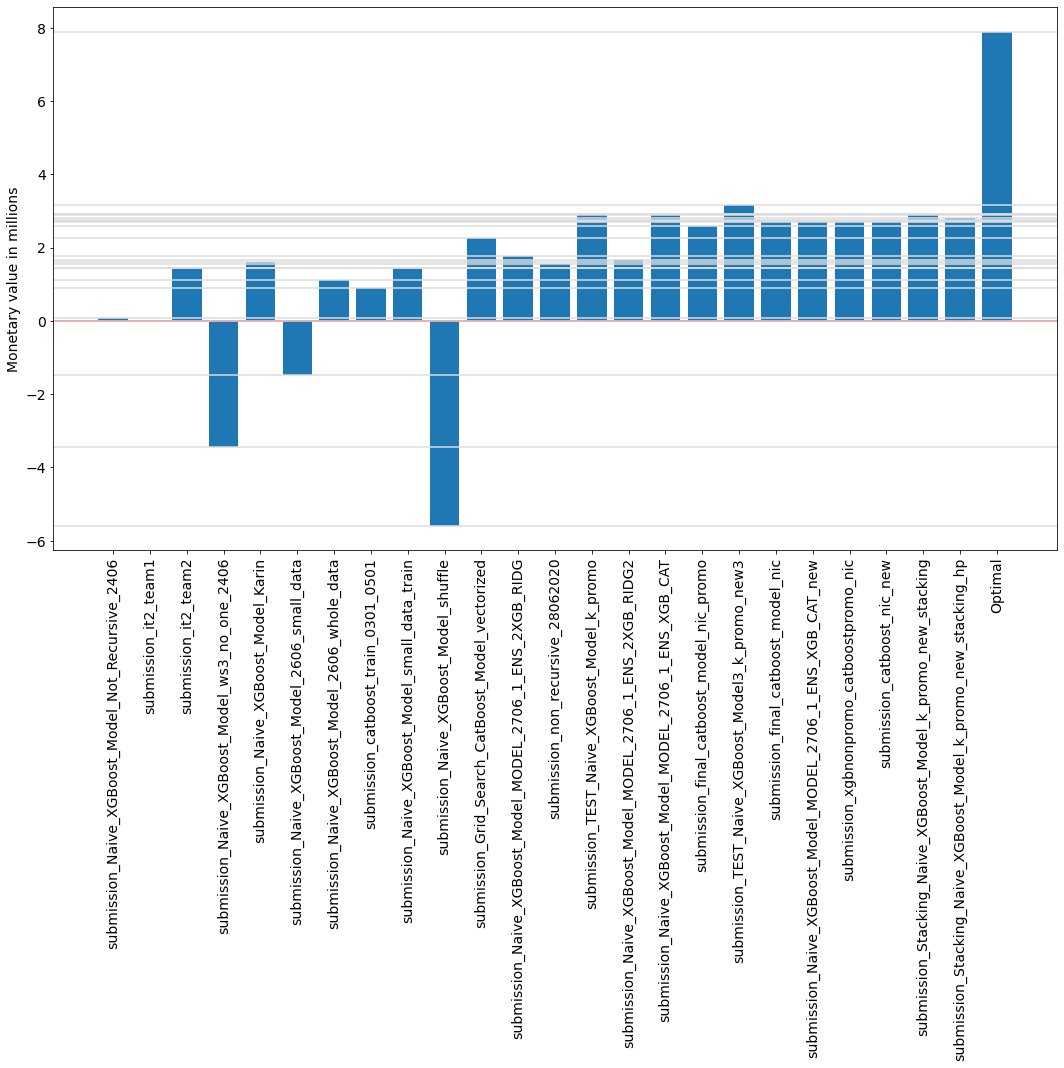

In [ ]:
columns = [*submissions_monet_val.keys(), 'Optimal']

mil = 1000000
solution_metrics = [*list(map(lambda x: x/mil, submissions_monet_val.values())), max_possible_mon_value/mil]
print(list((np.array(solution_metrics) < -1000)).index(False))
# for i in range(0, len(solution_metrics)-1):
#   if solution_metrics[i]<-100:
#     print(f"Deleting {columns[i]} because it would make others invisible")
#     solution_metrics.pop(i)
    # columns.pop(i)

plt.bar(columns, solution_metrics)
plt.axhline(y=0, color='red')
for i in solution_metrics:
  plt.axhline(y=i, color='#DDD')
plt.ylabel("Monetary value in millions", fontsize=14)
plt.gcf().set_size_inches((18, 10))
plt.tick_params(labelsize=14)
plt.xticks(rotation=90)

In [ ]:
# # Create plot for final presentation manually:
# solution_metrics_1 = [-8,0.9,1.6]
# plt.bar(["seq2seq","CatBoost","XGBoost"], solution_metrics_1)
# plt.axhline(y=0, color='red')
# for i in solution_metrics_1:
#   plt.axhline(y=i, color='#DDD')
# plt.ylabel("Monetary value in millions", fontsize=30)
# plt.gcf().set_size_inches((20, 15))
# plt.tick_params(labelsize=30)


In [ ]:
compare_sub = pd.DataFrame(solution_metrics, index=columns, columns=["Monetary Value"])
compare_sub.style.apply(highlight_max)

,Monetary Value
submission_Naive_XGBoost_Model_Not_Recursive_2406,0.087962
submission_it2_team1,0.001356
submission_it2_team2,1.444483
submission_Naive_XGBoost_Model_ws3_no_one_2406,-3.435027
submission_Naive_XGBoost_Model_Karin,1.616081
submission_Naive_XGBoost_Model_2606_small_data,-1.475253
submission_Naive_XGBoost_Model_2606_whole_data,1.122289
submission_catboost_train_0301_0501,0.905792
submission_Naive_XGBoost_Model_small_data_train,1.447902
submission_Naive_XGBoost_Model_shuffle,-5.588886


# Submission Analysis

Please specify which model should be analysed. Set the following variable to the csv filename. ```sample_submission.csv``` would end in the value : ```sample_submission```. The following values are showing all possible submissions.

In [ ]:
" | ".join(submissions_analysis.keys())

'submission_Naive_XGBoost_Model_Not_Recursive_2406 | submission_it2_team1 | submission_it2_team2 | submission_Naive_XGBoost_Model_ws3_no_one_2406 | submission_Naive_XGBoost_Model_Karin | submission_Naive_XGBoost_Model_2606_small_data | submission_Naive_XGBoost_Model_2606_whole_data | submission_catboost_train_0301_0501 | submission_Naive_XGBoost_Model_small_data_train | submission_Naive_XGBoost_Model_shuffle | submission_Grid_Search_CatBoost_Model_vectorized | submission_Naive_XGBoost_Model_MODEL_2706_1_ENS_2XGB_RIDG | submission_non_recursive_28062020 | submission_TEST_Naive_XGBoost_Model_k_promo | submission_Naive_XGBoost_Model_MODEL_2706_1_ENS_2XGB_RIDG2 | submission_TEST_Naive_XGBoost_Model_k_promo_new | submission_Naive_XGBoost_Model_MODEL_2706_1_ENS_XGB_CAT | submission_final_catboost_model_nic_promo | submission_TEST_Naive_XGBoost_Model3_k_promo_new3 | submission_final_catboost_model_nic | submission_Naive_XGBoost_Model_MODEL_2706_1_ENS_XGB_CAT_new'

In [ ]:
submission_to_analyse: str = 'submission_Naive_XGBoost_Model_MODEL_2706_1_ENS_2XGB_RIDG2'

### Monetary Value

In [ ]:
print(f"Monetary value of model {submission_to_analyse} is : {submissions_monet_val[submission_to_analyse]}")

Monetary value of model submission_Naive_XGBoost_Model_MODEL_2706_1_ENS_2XGB_RIDG2 is : 1672626.0


### Descriptive analysis of submissions

This values reflect the monetary value of each item. The mean for example describes the mean of monetary values over all the items

In [ ]:
submissions_analysis[submission_to_analyse].describe()

,demandPrediction,orders,difference,monetary_value,sim_price
count,10463.000000,10463.000000,10463.000000,10463.000000,10463.000000
mean,8.003632,26.317882,-18.314250,159.861035,122.010808
std,37.453462,108.263964,97.148295,1038.944943,469.701306
min,0.000000,0.000000,-2577.000000,-6522.560000,0.380000
25%,0.000000,0.000000,-2.000000,0.000000,8.990000
50%,0.000000,0.000000,0.000000,0.000000,23.830000
75%,0.000000,3.000000,0.000000,0.000000,63.125000
max,894.000000,2587.000000,647.000000,45856.800000,9055.070000


### First prediction

In [ ]:
submissions_analysis[submission_to_analyse][30:]

,demandPrediction,orders,difference,monetary_value,sim_price
itemID,,,,,
31,0,1.0,-1.0,0.0,14.12
32,0,0.0,0.0,0.0,32.09
33,0,0.0,0.0,0.0,44.12
34,0,0.0,0.0,0.0,80.28
35,0,17.0,-17.0,0.0,337.84
...,...,...,...,...,...
10459,0,0.0,0.0,0.0,14.71
10460,0,0.0,0.0,0.0,325.67
10461,0,0.0,0.0,0.0,190.53


## Histogramm
of the monetary value


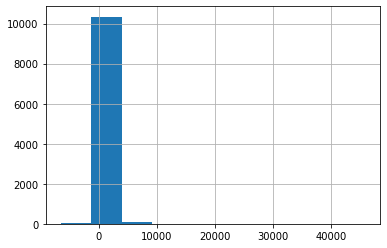

In [ ]:
submissions_analysis[submission_to_analyse]['monetary_value'].hist()

historgramm on the difference

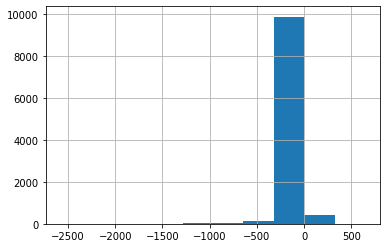

In [ ]:
submissions_analysis[submission_to_analyse]['difference'].hist()

## Plot of difference per Item ID


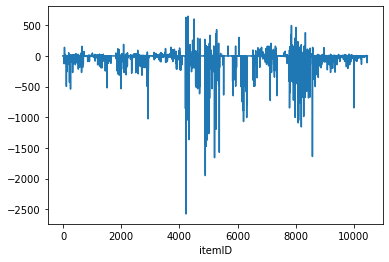

In [ ]:
submissions_analysis[submission_to_analyse]['difference'].plot()